# Image Classification - TensorFlow Tutorial

This tutorial shows how to classify images of flowers. It creates an image classifier using a keras.Sequential model, and loads data using preprocessing.image_dataset_from_directory. You will gain practical experience with the following concepts:

Efficiently loading a dataset off disk.
Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This dataset consists of 3700 photos of flowers and contains 5 sub-directories for five different flowers:

flower_photo/

  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 37s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

## Check Pictures of roses

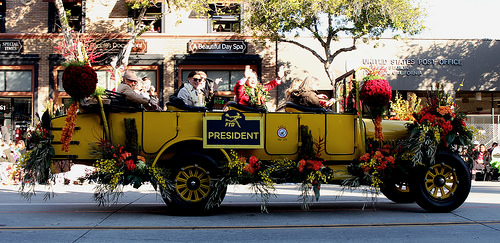

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

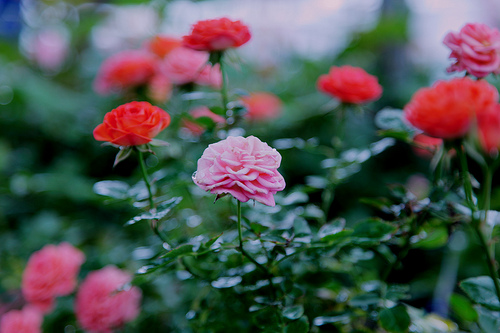

In [6]:
PIL.Image.open(str(roses[1]))

## Load Using keras.preprocessing

In [7]:
# Create a dataset

# define some parameters for the loader
batch_size = 32 # always seems to be a multiple of 16 (32 or 64)
img_height = 180
img_width = 180 

**Its good practice to use a validation split when developing your model.**

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
# create the validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
# find the class names
class_names = train_ds.class_names

## Visualise the Data

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

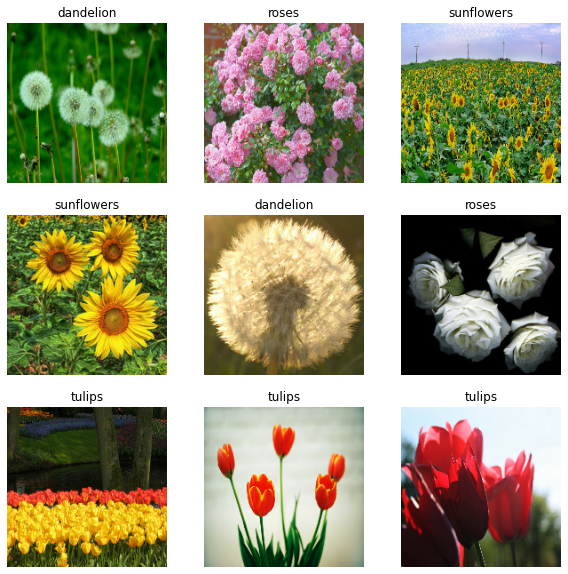

In [17]:
# create the figure size of the plot
plt.figure(figsize=(10, 10))
# loop through the images and their labels in the train set
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the Dataset for Performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# standardise the dataset
# divide by 255 for RGB

norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
# there are two ways to use this layer. You can apply it to the dataset by calling map

norm_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
image_batch, labels_batch = next(iter(norm_ds)) # next() is used to grab the next item in a collection
first_image = image_batch[0]
# check the valuues have been normalized
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Create the Model

In [25]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # 3 Channels (RGB)
    layers.Conv2D(16, 3, padding='same', activation='relu'), # padding is used to reduce information loss
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # flatten the image 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # final layer needs to match the number of classes input into the model
    layers.Dense(num_classes)
])

In [30]:
# Compile the Model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [31]:
# model summary 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [32]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 29s 317ms/step - loss: 1.3052 - accuracy: 0.4493 - val_loss: 1.1130 - val_accuracy: 0.5218
Epoch 2/10
92/92 [==============================] - 27s 297ms/step - loss: 1.0009 - accuracy: 0.6025 - val_loss: 0.9358 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 29s 314ms/step - loss: 0.8183 - accuracy: 0.6839 - val_loss: 0.9710 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 39s 427ms/step - loss: 0.6158 - accuracy: 0.7718 - val_loss: 0.8397 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 36s 387ms/step - loss: 0.4088 - accuracy: 0.8481 - val_loss: 0.9227 - val_accuracy: 0.6975
Epoch 6/10
92/92 [==============================] - 29s 318ms/step - loss: 0.2212 - accuracy: 0.9288 - val_loss: 1.1427 - val_accuracy: 0.6662
Epoch 7/10
92/92 [==============================] - 29s 319ms/step - loss: 0.1087 - accuracy: 0.9666 - val_loss: 1.3831 - val_accuracy: 0.6567

## Visualise the Training

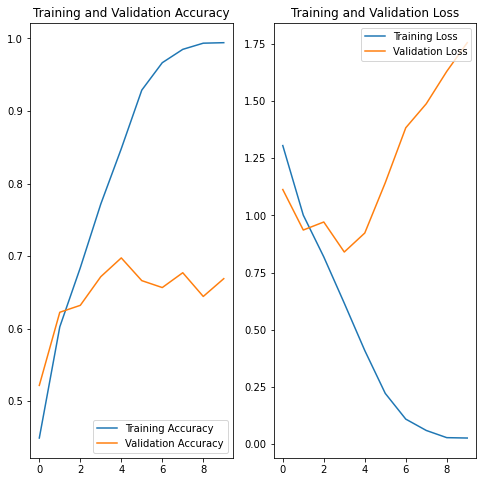

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training and validation accuracy are off by a large margin and the model has only acheived around 60% accuracy on the validation set.

This suggests **overfitting**

Models are susceptible to overfitting when there is a small number of training examples. It begins to learn for noises or unwanted details from the training examples which negatively impacts performance of the model on new (test) examples. 

To combat overfitting we are going to use **data augmentation** and **add dropout layers** to the model.

## Data Augmentation

Takes the approach of generating additional training data from exisiting examples by augmentation (rotation and other random transformations, exposing the model to more data).

In [36]:
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

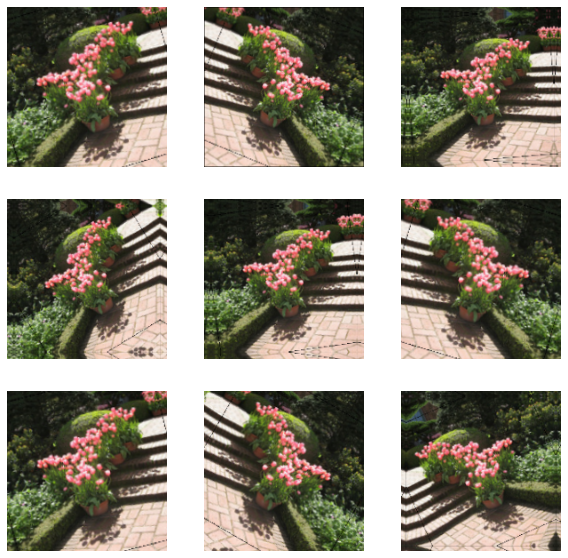

In [38]:
# visualise the augmentation (check its worked)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Dropout 

Dropout is a form of regularization.

Dropout randomly drops out (by setting the activation to 0) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1. This means dropping out 10% of the output randomly from the applied layer.

In [39]:
model = Sequential([
  data_aug, # using our data_aug layer as well
  layers.experimental.preprocessing.Rescaling(1./255),# normalise
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # randomly dropout 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the new model with Aug and Drop

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [42]:
# fit the model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
92/92 [==============================] - 36s 391ms/step - loss: 1.3607 - accuracy: 0.4033 - val_loss: 1.1682 - val_accuracy: 0.5014
Epoch 2/15
92/92 [==============================] - 39s 423ms/step - loss: 1.0879 - accuracy: 0.5630 - val_loss: 1.0188 - val_accuracy: 0.5967
Epoch 3/15
92/92 [==============================] - 46s 502ms/step - loss: 0.9815 - accuracy: 0.6059 - val_loss: 1.0318 - val_accuracy: 0.5886
Epoch 4/15
92/92 [==============================] - 42s 460ms/step - loss: 0.9255 - accuracy: 0.6335 - val_loss: 0.9104 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 38s 416ms/step - loss: 0.8540 - accuracy: 0.6666 - val_loss: 0.9111 - val_accuracy: 0.6485
Epoch 6/15
92/92 [==============================] - 36s 390ms/step - loss: 0.8042 - accuracy: 0.6860 - val_loss: 0.9330 - val_accuracy: 0.6390
Epoch 7/15
92/92 [==============================] - 37s 403ms/step - loss: 0.7779 - accuracy: 0.7050 - val_loss: 0.8060 - val_accuracy: 0.6866

## Visualise The training results (again)

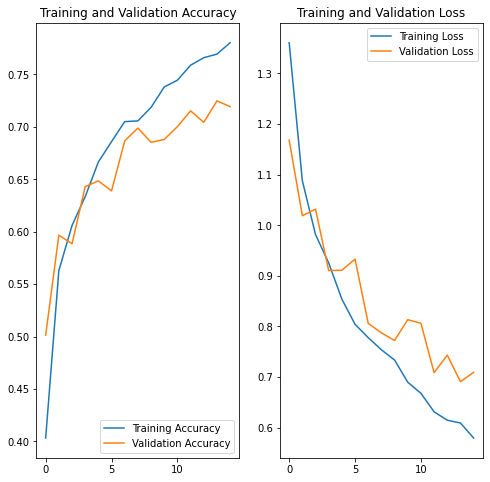

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()